In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '../DP/Data/glove.42B.300d.txt.zip'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, Dropout, Dense, LSTM, GRU


In [ ]:
dataset = pd.read_csv('../DP/Data/final_dataset_3.csv')

## Split datasetu

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## One-hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

## Embedding matica

In [ ]:
path_to_glove_file = 'glove.42B.300d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 1917494 word vectors.


In [ ]:
embeddings_index['happy'].shape

(300,)

In [ ]:
embedding_dim = 300
vocab_size = 40000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(X_train.values)

In [ ]:
voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
voc[:10]

['', '[UNK]', 's', 'would', 'one', 'could', 'man', 'time', 'upon', 'said']

In [ ]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 37419 words (2581 misses)


# Modely

## Dense model

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.GlobalAveragePooling1D()(emb)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
output_layer =  keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 6000, 300)         12000600  
                                                                 
 global_average_pooling1d (  (None, 300)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1024)              308224

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
44/44 [==============================] - 142s 3s/step - loss: 2.7640 - accuracy: 0.1631 - val_loss: 2.4022 - val_accuracy: 0.3077
Epoch 2/15
44/44 [==============================] - 124s 3s/step - loss: 1.9961 - accuracy: 0.4167 - val_loss: 1.6341 - val_accuracy: 0.5385
Epoch 3/15
44/44 [==============================] - 137s 3s/step - loss: 1.4257 - accuracy: 0.5648 - val_loss: 1.2086 - val_accuracy: 0.6410
Epoch 4/15
44/44 [==============================] - 124s 3s/step - loss: 1.0692 - accuracy: 0.6959 - val_loss: 0.8744 - val_accuracy: 0.7885
Epoch 5/15
44/44 [==============================] - 139s 3s/step - loss: 0.9229 - accuracy: 0.7258 - val_loss: 0.8099 - val_accuracy: 0.7949
Epoch 6/15
44/44 [==============================] - 129s 3s/step - loss: 0.7657 - accuracy: 0.7756 - val_loss: 0.6498 - val_accuracy: 0.8397
Epoch 7/15
44/44 [==============================] - 3s 65ms/step - loss: 0.6503 - accuracy: 0.8113 - val_loss: 0.6513 - val_accuracy: 0.8141
Epoch 8/15
44

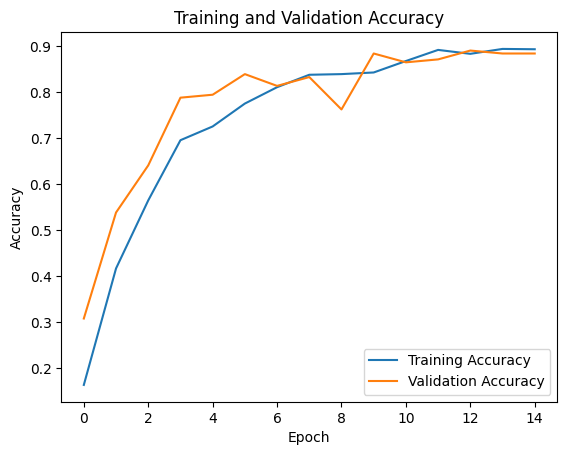

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

13/13 [==============================] - 1s 48ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.8849104859335039
F1 Score: 0.8836528042794201
Precision: 0.897165600720341
Recall: 0.8849104859335039


## CNN Model

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(emb)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 6000, 300)         12000600  
                                                                 
 conv1d (Conv1D)             (None, 5997, 512)         614912    
                                                                 
 max_pooling1d (MaxPooling1  (None, 2998, 512)         0         
 D)                                                              
                                                                 
 global_average_pooling1d_1  (None, 512)               0   

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
44/44 [==============================] - 143s 3s/step - loss: 2.5942 - accuracy: 0.2365 - val_loss: 2.1074 - val_accuracy: 0.3269
Epoch 2/15
44/44 [==============================] - 135s 3s/step - loss: 1.8586 - accuracy: 0.4573 - val_loss: 1.6000 - val_accuracy: 0.4744
Epoch 3/15
44/44 [==============================] - 136s 3s/step - loss: 1.5118 - accuracy: 0.5655 - val_loss: 1.2485 - val_accuracy: 0.7372
Epoch 4/15
44/44 [==============================] - 133s 3s/step - loss: 1.1914 - accuracy: 0.7080 - val_loss: 1.0148 - val_accuracy: 0.7756
Epoch 5/15
44/44 [==============================] - 133s 3s/step - loss: 0.9774 - accuracy: 0.7372 - val_loss: 0.8996 - val_accuracy: 0.7564
Epoch 6/15
44/44 [==============================] - 135s 3s/step - loss: 0.8136 - accuracy: 0.7806 - val_loss: 0.7165 - val_accuracy: 0.8077
Epoch 7/15
44/44 [==============================] - 144s 3s/step - loss: 0.7051 - accuracy: 0.8141 - val_loss: 0.6393 - val_accuracy: 0.8462
Epoch 8/15
44

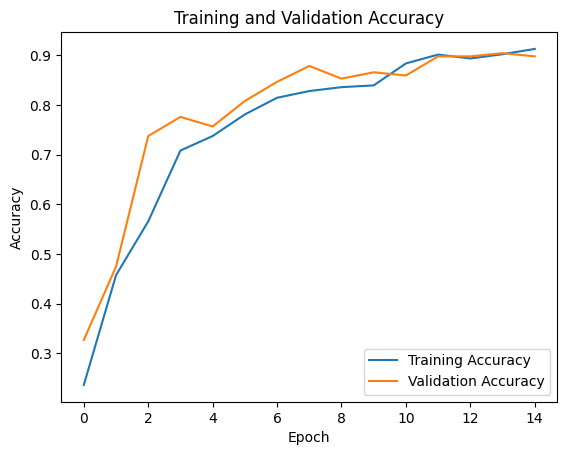

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

13/13 [==============================] - 1s 102ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.9002557544757033
F1 Score: 0.901869960164759
Precision: 0.9129432427877607
Recall: 0.9002557544757033


## Biderectional LSTMU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(emb)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(256, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 6000, 300)         12000600  
                                                                 
 bidirectional (Bidirection  (None, 6000, 256)         439296    
 al)                                                             
                                                                 
 global_average_pooling1d_2  (None, 256)               0         
  (GlobalAveragePooling1D)                                       
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
44/44 [==============================] - 161s 4s/step - loss: 2.8142 - accuracy: 0.1425 - val_loss: 2.4506 - val_accuracy: 0.2244
Epoch 2/15
44/44 [==============================] - 154s 4s/step - loss: 2.0925 - accuracy: 0.3412 - val_loss: 1.6959 - val_accuracy: 0.4679
Epoch 3/15
44/44 [==============================] - 146s 3s/step - loss: 1.6447 - accuracy: 0.4751 - val_loss: 1.5024 - val_accuracy: 0.4808
Epoch 4/15
44/44 [==============================] - 159s 4s/step - loss: 1.3277 - accuracy: 0.5712 - val_loss: 1.2863 - val_accuracy: 0.5128
Epoch 5/15
44/44 [==============================] - 142s 3s/step - loss: 1.1748 - accuracy: 0.6239 - val_loss: 1.1110 - val_accuracy: 0.6731
Epoch 6/15
44/44 [==============================] - 159s 4s/step - loss: 0.9661 - accuracy: 0.6766 - val_loss: 0.8813 - val_accuracy: 0.7821
Epoch 7/15
44/44 [==============================] - 142s 3s/step - loss: 0.8772 - accuracy: 0.7123 - val_loss: 0.8119 - val_accuracy: 0.7692
Epoch 8/15
44

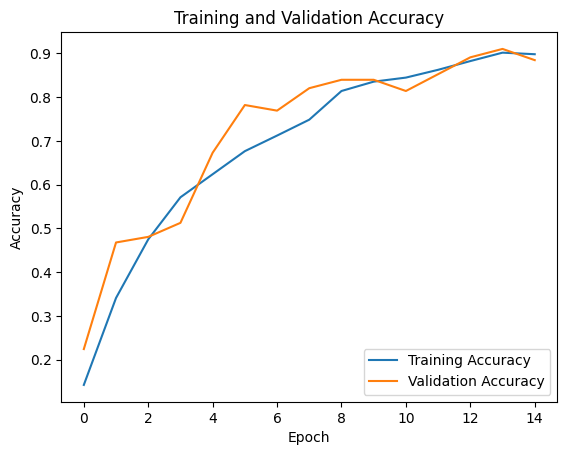

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

13/13 [==============================] - 3s 206ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.8797953964194374
F1 Score: 0.8800034546011696
Precision: 0.8905540294083997
Recall: 0.8797953964194374


## LSTM + GRU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.LSTM(256, return_sequences=True)(emb)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.GRU(128, return_sequences=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.1)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)


model = keras.Model(input_layer, output_layer)
model.summary()


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 6000, 300)         12000600  
                                                                 
 lstm_1 (LSTM)               (None, 6000, 256)         570368    
                                                                 
 dropout_5 (Dropout)         (None, 6000, 256)         0         
                                                                 
 gru (GRU)                   (None, 128)               148224    
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
44/44 [==============================] - 169s 4s/step - loss: 2.9112 - accuracy: 0.1118 - val_loss: 2.8596 - val_accuracy: 0.1026
Epoch 2/15
44/44 [==============================] - 152s 4s/step - loss: 2.7225 - accuracy: 0.1389 - val_loss: 2.7658 - val_accuracy: 0.1218
Epoch 3/15
44/44 [==============================] - 152s 4s/step - loss: 2.5725 - accuracy: 0.1731 - val_loss: 2.7502 - val_accuracy: 0.1282
Epoch 4/15
44/44 [==============================] - 153s 4s/step - loss: 2.4541 - accuracy: 0.2194 - val_loss: 2.6631 - val_accuracy: 0.1474
Epoch 5/15
44/44 [==============================] - 29s 657ms/step - loss: 2.3643 - accuracy: 0.2343 - val_loss: 2.6708 - val_accuracy: 0.2115
Epoch 6/15
44/44 [==============================] - 151s 3s/step - loss: 2.1341 - accuracy: 0.3070 - val_loss: 2.5607 - val_accuracy: 0.2436
Epoch 7/15
44/44 [==============================] - 26s 595ms/step - loss: 2.0473 - accuracy: 0.3298 - val_loss: 2.6836 - val_accuracy: 0.2372
Epoch 8/1

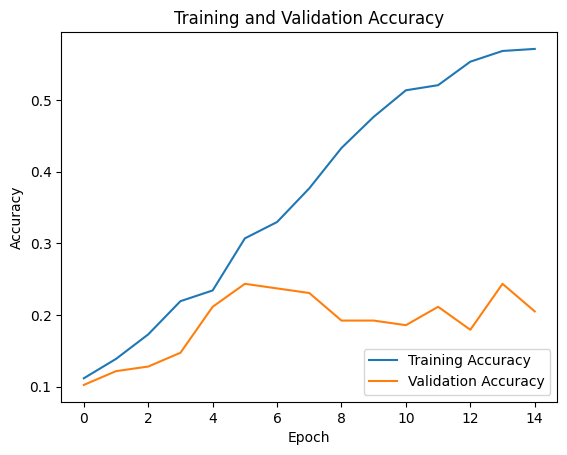

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

13/13 [==============================] - 4s 237ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.23273657289002558
F1 Score: 0.20436704144615572
Precision: 0.26270162181287504
Recall: 0.23273657289002558
